In [1]:
import tensorflow as tf
import numpy as np
import mdn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from timeit import default_timer as timer
import xgboost as xgb

bin_count = 171

In [2]:
def find_first_zero(row):
    vals = list(row) 
  
    last_zero_index = -1
    for idx, val in enumerate(reversed(vals)): 
        if val > 0:
            last_zero_index = bin_count - idx
            break
    return last_zero_index

def create_test_train(data_set_path, test_size=0.10):
    """ Splits a given csv file into testing and training. Target column is all the bins. Add a c """
    # Make sure the columns are set
    data_set = pd.read_csv(data_set_path)

    # Add column for classifying whether the output has most of the data in the last 10 bins.
    end_average = data_set[[f'Output_Bin_{i}' for i in range(bin_count-10, bin_count)]].sum(axis=1) > 0.9

    data_set['Output_Is_End'] = end_average
    data_set['Output_Is_End'] = data_set['Output_Is_End'].astype(int)
    #data_set['Output_Is_Not_End'] = ~data_set['Output_Is_End']
    
    

    data_set['Output_First_Zero'] = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]].apply(find_first_zero, axis=1)

    # Shuffle the data
    data_set = data_set.sample(frac=1, random_state=0)
 
    # Select all except output bins
    data_set_X = data_set.drop([f'Output_Bin_{i}' for i in range(bin_count)] + ['Output_Is_End', 'Output_First_Zero'], axis=1)
    # Select only the output bins
    data_set_Y = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]+ ['Output_Is_End', 'Output_First_Zero']]

    #Split into training and test data
    return train_test_split(data_set_X,
                            data_set_Y,
                            test_size=test_size, 
                            random_state=300)

filename= "/project/SDS-capstones-kropko21/uva-astronomy/dust_training_data_all_bins_v2.csv"
X_train, X_test, y_train, y_test = create_test_train(filename, test_size=0.10)
display(y_test.describe())

,Output_Bin_0,Output_Bin_1,Output_Bin_2,Output_Bin_3,Output_Bin_4,Output_Bin_5,Output_Bin_6,Output_Bin_7,Output_Bin_8,Output_Bin_9,...,Output_Bin_163,Output_Bin_164,Output_Bin_165,Output_Bin_166,Output_Bin_167,Output_Bin_168,Output_Bin_169,Output_Bin_170,Output_Is_End,Output_First_Zero
count,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,...,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000
mean,4.788404e-03,3.511234e-03,3.102781e-03,3.476701e-03,3.457728e-03,3.501525e-03,3.642096e-03,3.778553e-03,3.935451e-03,4.021584e-03,...,0.001058,0.000883,0.000728,0.000676,0.001939,0.005278,0.016270,0.151275,0.167596,114.466395
std,1.166852e-02,7.803030e-03,6.573299e-03,7.853398e-03,6.781768e-03,6.542634e-03,6.904298e-03,6.660142e-03,7.485042e-03,6.836560e-03,...,0.006218,0.005424,0.004790,0.004623,0.006232,0.013469,0.040799,0.326542,0.373509,41.073065
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000
25%,1.413419e-11,5.957408e-11,2.004835e-10,7.735218e-10,2.203720e-09,4.972974e-09,1.233129e-08,2.641020e-08,5.567167e-08,1.080826e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,81.000000
50%,1.091139e-04,1.224256e-04,1.354748e-04,1.791490e-04,2.160863e-04,2.491617e-04,2.911052e-04,3.537974e-04,4.251557e-04,5.010170e-04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,110.000000
75%,2.666961e-03,2.534129e-03,2.509944e-03,2.984808e-03,3.315966e-03,3.667415e-03,4.060019e-03,4.502340e-03,4.900773e-03,5.306905e-03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,157.000000
max,9.354140e-02,5.693502e-02,4.501455e-02,3.978454e-01,1.493864e-01,3.745879e-02,2.716096e-01,3.748155e-02,3.097229e-01,1.159227e-01,...,0.087176,0.087361,0.087655,0.091350,0.105380,0.133252,0.245536,0.999991,1.000000,171.000000


Try xgboost for predicting whether all the particles are at the end of the distribution. Ended up getting over 99% test accuracy.

In [4]:
#%pip install xgboost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              n_estimators = 25,
                              random_state=42)
xgb_model.fit(X_train, y_train['Output_Is_End'],
             eval_set=[(X_train, y_train['Output_Is_End']), (X_test, y_test['Output_Is_End'])],
             eval_metric='error',verbose=True)

evals_result = xgb_model.evals_result()

[0]	validation_0-error:0.00974	validation_1-error:0.00952
[1]	validation_0-error:0.00879	validation_1-error:0.00856
[2]	validation_0-error:0.00685	validation_1-error:0.00670
[3]	validation_0-error:0.00648	validation_1-error:0.00634
[4]	validation_0-error:0.00584	validation_1-error:0.00569
[5]	validation_0-error:0.00535	validation_1-error:0.00522
[6]	validation_0-error:0.00490	validation_1-error:0.00490
[7]	validation_0-error:0.00457	validation_1-error:0.00463
[8]	validation_0-error:0.00407	validation_1-error:0.00431
[9]	validation_0-error:0.00383	validation_1-error:0.00407
[10]	validation_0-error:0.00365	validation_1-error:0.00396
[11]	validation_0-error:0.00346	validation_1-error:0.00371
[12]	validation_0-error:0.00308	validation_1-error:0.00339
[13]	validation_0-error:0.00302	validation_1-error:0.00331
[14]	validation_0-error:0.00279	validation_1-error:0.00306
[15]	validation_0-error:0.00261	validation_1-error:0.00292
[16]	validation_0-error:0.00232	validation_1-error:0.00266
[17]	va

In [5]:
preds = xgb_model.predict(X_test)

# Count the number of matches between predictions and labels
correct = np.sum(preds == y_test['Output_Is_End'])

# Calculate accuracy
accuracy = correct / len(y_test)
print(f"Accuracy: {accuracy}")

#xgb_model.save_model('xgb_model_is_end.model')

Accuracy: 0.9982013630295792


Train a linear regression model for predicting when first zero occurs on models where the dust is not all stacked at the end.

In [ ]:

xgb_model_reg = xgb.XGBRegressor(objective="reg:squarederror",
                             eta=0.1,
                             n_estimators=50,
                             sub_sample=0.8,
                             colsample_bytree=0.8,
                             max_depth=8,
                              random_state=42)


# Only train on output not at end
output_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]
X_first_zero = X_train.loc[output_not_end_idx]
y_first_zero = y_train.loc[output_not_end_idx, 'Output_First_Zero']

xgb_model_reg.fit(X_first_zero, y_first_zero,
             eval_set=[(X_first_zero, y_first_zero)],
             eval_metric='rmse', early_stopping_rounds=10, verbose=True)

evals_result = xgb_model_reg.evals_result()

[12:22:08] WARNING: ../src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:97.75924
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:88.06432
[2]	validation_0-rmse:79.34386
[3]	validation_0-rmse:71.51508
[4]	validation_0-rmse:64.46444
[5]	validation_0-rmse:58.09127
[6]	validation_0-rmse:52.36957
[7]	validation_0-rmse:47.21400
[8]	validation_0-rmse:42.57171
[9]	validation_0-rmse:38.40007
[10]	validation_0-rmse:34.64150
[11]	validation_0-rmse:31.26425
[12]	validation_0-rmse:28.23025
[13]	validation_0-rmse:25.50051
[14]	validation_0-rmse:23.05045
[15]	validation_0-rmse:20.85666
[16]	validation_0-rmse:18.87474
[17]	validation_0-rmse:17.09493
[18]	validation_0-rmse:15.50703
[19]	va

Best train result is 1.116 RMSE. Best test RMSE is 1.3

In [6]:
from sklearn.metrics import mean_squared_error as MSE 

#Optionally load pretrained model
# Load first zero model
#xgb_model = xgb.XGBRegressor()
#xgb_model.load_model('xgb_model_first_zero.model')

# Only predict on output not at end
output_not_end_test_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]
X_test_first_zero = X_test.loc[output_not_end_test_idx]
y_test_first_zero = y_test.loc[output_not_end_test_idx, 'Output_First_Zero']

# Predict the model. Round preds since bins are whole numbers
pred = np.rint(xgb_model.predict(X_test_first_zero)) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(y_test_first_zero, pred)) 
print(f"RMSE : {rmse}") 

pd.set_option('display.max_rows', None)
print(pd.DataFrame({"preds":pred, "test":y_test_first_zero}).head(25))

RMSE : 1.3883092322193251
        preds  test
509706  108.0   108
280992  133.0   133
589362  101.0   100
100403   99.0    99
569818  102.0   102
747556   60.0    60
162103  149.0   149
763711   38.0    31
175986  147.0   147
773247   40.0    46
599540   71.0    71
196468  119.0   117
728162   60.0    60
794035   77.0    77
429222  116.0   116
622139  127.0   127
460440  121.0   121
96798    99.0    99
662134   90.0    90
229566   87.0    86
520709   83.0    84
614446   72.0    72
577202  101.0   101
198813   86.0    86
657359  106.0   107


In [33]:
xgb_model.save_model('xgb_model_first_zero.model')

Train two MDNs, one on the dust at end and one without

In [34]:
def build_mdn_model(activation='sigmoid', k=16):
    """ k is the number of mixture models"""
    # Number of columns (bin count plus 8 inputs)
    l = bin_count + 8

    # Network
    input = tf.keras.Input(shape=(l,))

    layer = tf.keras.layers.Dense(512, activation=activation, name='baselayer')(input)
    layer_2 = tf.keras.layers.Dense(128, activation=activation, name='layer_2')(layer)
    layer_3 = tf.keras.layers.Dense(64, activation=activation, name='layer_3')(layer_2)
    #layer_4 = tf.keras.layers.Dense(32, activation=activation, name='layer_4')(layer_3)

    # Connect the mdn layer to the output of our neural network
    mdn_layer = mdn.MDN(bin_count,k, name='mdn')(layer_3)
    model = tf.keras.models.Model(input, [mdn_layer])


    opt = tf.keras.optimizers.Adam()
    model.compile(loss=mdn.get_mixture_loss_func(bin_count,k), optimizer=opt)
    model.summary()
    return model

Build a mdn model for the outputs where the dust is at the end of the distribution

In [35]:

#model_spike = build_mdn_model(k=64)
model_spike = build_mdn_model(k=32)
output_is_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 1]

X = X_train.loc[output_is_end_idx]
y = y_train.loc[output_is_end_idx].drop(['Output_Is_End', 'Output_First_Zero'], axis=1)
print(y.shape)
spike_fit = model_spike.fit(x=X, y=y, batch_size=512, epochs=200, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 159)]             0         
_________________________________________________________________
baselayer (Dense)            (None, 512)               81920     
_________________________________________________________________
layer_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
layer_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
mdn (MDN)                    (None, 9696)              630240    
Total params: 786,080
Trainable params: 786,080
Non-trainable params: 0
_________________________________________________________________
(176325, 151)
Epoch 1/200
310/310 [==============================] - 12s 37ms/step - loss: -448.6376 - val_loss: 

In [36]:
model_spike.save("spiked_mdn_model/model")

INFO:tensorflow:Assets written to: spiked_mdn_model/model/assets


In [3]:
from scipy.stats import entropy
def predict_for_test(model, X_test, y_test, k):

    start = timer()

    # Returns the predictions of the parameters of the distributions and weights
    preds = model.predict(X_test)
    samples_list = []
    # Obtain 5 samples per prediction
    for i in range(5):
        samples_list.append(np.apply_along_axis(mdn.sample_from_output, 1, preds, bin_count, k, temp=1.0, sigma_temp=1.0))

    # Average the samples for our predicitons
    y_samples = np.mean(np.array(samples_list),axis=0)
    y_samples = y_samples.reshape(len(X_test),bin_count)
    # Convert negatives to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    end = timer()
    
    print(f"Total time taken: {end-start}. Seconds per prediction: {(end-start)/len(preds)}")
    
    return y_samples

Make predictions for this model and evaluate the results

In [4]:
output_is_end_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 1]

X_test_spike = X_test.loc[output_is_end_idx]
y_test_spike = y_test.loc[output_is_end_idx].drop(['Output_Is_End','Output_First_Zero'], axis=1)

model_spike = tf.keras.models.load_model('spiked_mdn_model/model', custom_objects={'MDN': mdn.MDN, 'mdn_loss_func': mdn.get_mixture_loss_func(1, 32)})


spike_preds = predict_for_test(model_spike, X_test_spike, y_test_spike, 32)
#spike_preds = model_spike.predict(X_test)

Total time taken: 253.24760373681784. Seconds per prediction: 0.012881363364029392


In [ ]:
from scipy.stats import entropy
def evaluate_fit(y_samples, y_test):
    ent = []

    # Turn all negative preds to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    # Small constant to prevent inf for 0s
    c = 1e-100
    
    y_samples += c
    y_test += c
    
    for i in range(len(y_test)):
        e = entropy(y_test.iloc[i], y_samples[i])
        ent.append(e if e != np.inf else 1000)   
    display(pd.DataFrame(ent).describe())

The entropy numbers are very high, but the graphs look similar

In [6]:
evaluate_fit(spike_preds, y_test_spike)

,0
count,19660.000000
mean,7.834118
std,15.420871
min,0.031026
25%,0.917441
50%,2.879487
75%,4.790842
max,116.308030


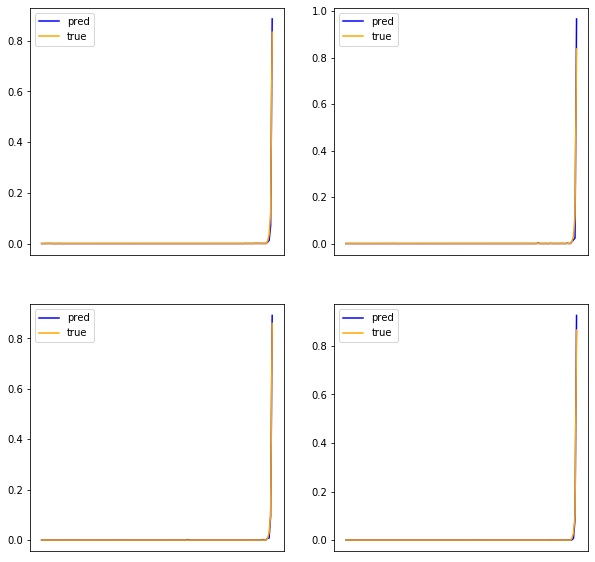

In [9]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_spike), size=1)[0]
    test_pred = spike_preds[i]
    true = y_test_spike.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    
plt.show()

Create a seperate mdn model to use on the rest.

Identify what type of distribution the non-spiked data is from y-train

In [5]:
#!pip install statsmodels
from distfit import distfit
from tqdm import tqdm
#st.norm, st.expon, st.pareto, st.dweibull, st.t, st.genextreme, st.gamma, st.lognorm, st.beta
dist = distfit(distr=['norm', 'lognorm', 'gamma', 'laplace','dweibull', 'genlogistic', 'beta', 'genextreme', 'exponnorm'])
output_is_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]
# Scale our data to our bins
model_names = {}
print(len(y_train))
#Randomnly pick 5000 indexes
#johnsonb?
for idx, data in tqdm(y_train.loc[output_is_not_end_idx].drop(['Output_Is_End', 'Output_First_Zero'], axis=1).sample(2500, axis=0).iterrows()):
    t = np.floor(np.multiply(data.values,bin_count))
    new_samp = []
    for idx, e in enumerate(t):
        if e:
            # To generate our samples add the bin number e number of times
            new_samp.extend([idx for _  in range(int(e))])
    # Fit the distribution to our data
    if len(new_samp) == 0:
        print('no samps')
        continue
    else:
        dist.fit_transform(np.array(new_samp), verbose=1)
        best_model = dist.model['name']
        #print(dist.model['params'])
        try:
            model_names[best_model] += 1
        except KeyError:
            model_names[best_model] = 1
print(model_names)

720304


2500it [14:31,  2.87it/s]

{'genlogistic': 1680, 'beta': 509, 'genextreme': 173, 'gamma': 5, 'dweibull': 120, 'exponnorm': 7, 'norm': 6}


In [23]:
model_non_spike = build_mdn_model()

output_is_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]

X = X_train.loc[output_is_not_end_idx]
y = y_train.loc[output_is_not_end_idx].drop(['Output_Is_End', 'Output_First_Zero'], axis=1)
non_spike_fit = model_non_spike.fit(x=X, y=y, batch_size=1024, epochs=25, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 159)]             0         
_________________________________________________________________
baselayer (Dense)            (None, 128)               20480     
_________________________________________________________________
mdn (MDN)                    (None, 4848)              625392    
Total params: 645,872
Trainable params: 645,872
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
479/479 [==============================] - 26s 54ms/step - loss: -421.1615 - val_loss: -450.0800
Epoch 2/25
479/479 [==============================] - 24s 51ms/step - loss: -467.3605 - val_loss: -464.8155
Epoch 3/25
479/479 [==============================] - 24s 51ms/step - loss: -470.0327 - val_loss: -463.4798
Epoch 4/25
479/479 [==============================] - 

In [24]:
output_is_not_end_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]

X_test_non_spike = X_test.loc[output_is_not_end_idx]
y_test_non_spike = y_test.loc[output_is_not_end_idx].drop(['Output_Is_End','Output_First_Zero'], axis=1)

non_spike_preds = predict_for_test(model_non_spike, X_test_non_spike, y_test_non_spike, 16)

Total time taken: 713.8454396454617. Seconds per prediction: 0.011823722788708082


In [25]:
evaluate_fit(non_spike_preds, y_test_non_spike)

,0
count,60374.000000
mean,59.828494
std,40.482187
min,0.875193
25%,31.162486
50%,51.231835
75%,81.241800
max,200.490032


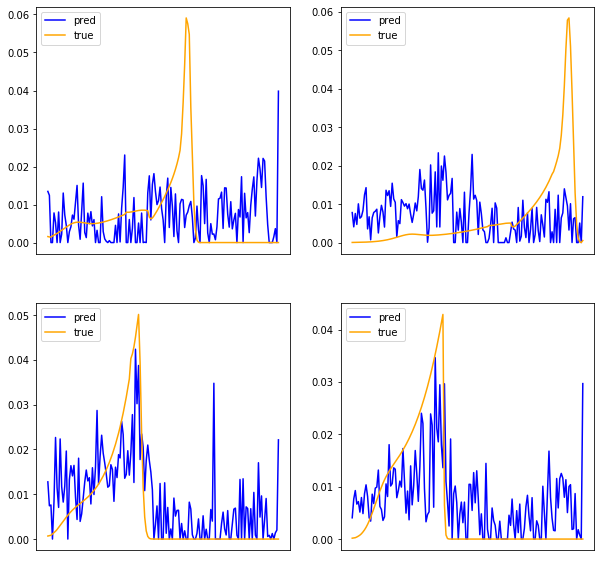

In [27]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_spike), size=1)[0]
    test_pred = non_spike_preds[i]
    true = y_test_non_spike.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    
plt.show()